In [2]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
import numpy as np
from os.path import join
import mat73
import matplotlib.pyplot as plt
import optuna

In [3]:
# Load data into dictionary
DataPath = join("neuro_data","dataSubj10.mat")
data_dict = mat73.loadmat(DataPath, use_attrdict=True)

RAWDATA = data_dict["data"]
BATCH_SIZE=16
## CROPPING for data, 2.6s-5.6s, region of interest with audio
FS = 512
LO = int(2.6*FS) #1331
HI = int(5.5*FS) #2816
# Dif : 1485 = 3 * 3 * 3 * 5 * 11

In [4]:
class CreateDataset(Dataset):
    """Creates dataset for EEGNET, meaning move all relevant channel data into one matrix for x, and results into y

    Args:
        Dataset (_type_): Takes in data loaded from Matlab and formats appropriately.
    """
    
    def __init__(self, data, channels, crop=None):
        # Associates channel names with channel data in a dictionary
        datadicts = [dict(zip(np.squeeze(data["label"]),dat)) for dat in data["trial"]]

        x, y = [0]*len(data["trialinfo"]), np.array([0]*len(data["trialinfo"]))
        
        # Extract the y-values, i.e. which side the audio was played
        for i, trialinfo in enumerate(data["trialinfo"]):
            # side : left = 1, right = 0
            y[i] = int(trialinfo[0]["side"])==1
        
        self.y = y
        
        # Extract only information from relevant channels
        for i, dat in enumerate(datadicts):
            x[i] = [dat[ch] for ch in channels]
        x = np.array(x)
        
        # Include only specific section of time-series.
        if crop:
            x=x[:,:,crop[0]:crop[1]]
        
        self.x = x

    def __getitem__(self, index):
        feature = torch.tensor([self.x[index]], dtype=torch.float32)
        label = torch.tensor([self.y[index]], dtype=torch.float32)

        return feature, label
    
    def __len__(self):
        return len(self.x)
        

In [5]:
# https://towardsdatascience.com/convolutional-neural-networks-for-eeg-brain-computer-interfaces-9ee9f3dd2b81
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class EEGNET(nn.Module):
    ''' Dimensions of key layers.
    in:
    [BATCH_SIZE,1,N_CHANNELS,HI-LO]
    temporal:
    [BATCH_SIZE,filter_sizing,N_CHANNELS,HI-LO]
    spatial:
    [BATCH_SIZE,filter_sizing*D,1,HI-LO]
    avgpool1:
    [BATCH_SIZE,filter_sizing*D,1,(HI-LO-mean_pool)/mean_pool + 1]
    avgpool2:
    [BATCH_SIZE,filter_sizing*D,1,floor((floor((HI-LO-mean_pool)/mean_pool + 1)-mean_pool)/mean_pool + 1)]
    '''
    def __init__(self, filter_sizing, dropout, D, channel_amount, receptive_field=512, mean_pool=15):
        super(EEGNET,self).__init__()
        self.temporal=nn.Sequential(
            nn.Conv2d(1,filter_sizing,kernel_size=[1,receptive_field],stride=1, bias=False,\
                padding='same'), 
            nn.BatchNorm2d(filter_sizing),
        )
        self.spatial=nn.Sequential(
            nn.Conv2d(filter_sizing,filter_sizing*D,kernel_size=[channel_amount,1],bias=False,\
                groups=filter_sizing),
            nn.BatchNorm2d(filter_sizing*D),
            nn.ELU(True),
        )

        self.seperable=nn.Sequential(
            nn.Conv2d(filter_sizing*D,filter_sizing*D,kernel_size=[1,16],\
                padding='same',groups=filter_sizing*D, bias=False),
            nn.Conv2d(filter_sizing*D,filter_sizing*D,kernel_size=[1,1], padding='same',groups=1, bias=False),
            nn.BatchNorm2d(filter_sizing*D),
            nn.ELU(True),
        )

        self.avgpool1 = nn.AvgPool2d([1, mean_pool], stride=[1, mean_pool], padding=0)   
        self.avgpool2 = nn.AvgPool2d([1, mean_pool], stride=[1, mean_pool], padding=0)
        self.dropout = nn.Dropout(dropout)
        self.view = nn.Sequential(Flatten())

        # Endsize calculated from dimensions given in documentation for Conv2d, AvgPool2d and Flatten.
        endsize = filter_sizing*D*np.floor((np.floor((HI-LO-mean_pool)/mean_pool + 1)-mean_pool)/mean_pool + 1)
        self.fc2 = nn.Linear(int(endsize), 1)

    def forward(self,x):
        out = self.temporal(x)
        out = self.spatial(out)
        out = self.avgpool1(out)
        out = self.dropout(out)
        out = self.seperable(out)
        out = self.avgpool2(out)
        out = self.dropout(out)
        out = out.view(out.size(0), -1)
        prediction = self.fc2(out)
        return torch.sigmoid(prediction)

In [6]:
def evaluate_loss(model, criterion, dataloader):
    model.eval()
    total_loss = 0.0
    for batch_X, batch_y in dataloader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        total_loss += loss.item()
        
    return total_loss / len(dataloader)

In [7]:
def evaluate_acc(model, dataloader):
    model.eval()
    total_acc = 0.0
    for batch_X, batch_y in dataloader:
        outputs = model(batch_X)
        predictions = 1.0*(outputs>0.5)
        total_acc += (predictions==batch_y).sum()
        
    return total_acc / len(dataloader.dataset)

In [8]:
def train(model, criterion, optimizer, train_loader, valid_loader, n_epochs):
    train_loss_list = []
    valid_loss_list = []
    train_acc_list = []
    valid_acc_list = []
    for epoch in range(1, n_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            ypred = model.forward(batch_X)
            loss = criterion(ypred, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        train_loss = evaluate_loss(model, criterion, train_loader)
        valid_loss = evaluate_loss(model, criterion, valid_loader)
        train_acc = evaluate_acc(model, train_loader)
        valid_acc = evaluate_acc(model, valid_loader)
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)

        print(f"| epoch {epoch:2d} | train loss {train_loss:.6f} | train acc {train_acc:.6f} | valid loss {valid_loss:.6f} | valid acc {valid_acc:.6f} |")

    return train_loss_list, valid_loss_list, train_acc_list, valid_acc_list

## Preparation for tuning and training

Set a seed to ensure consistency through runs.

In [9]:
# fix random seed
np.random.seed(293210931)
torch.manual_seed(293210931)

channels = ["T7","FT7","TP7","TP8","FT8","T8"]
N_CHANNELS = len(channels)

DATASET = CreateDataset(RAWDATA, channels, [LO, HI])


# Hyperparam optimization Optuna

Here I attempt to optimize hyper parameter choice to maximize accuracy on validation data.

I save some test data that is untouched during hyperparameter tuning, this is used for evaluation.

In [10]:
# Partition into training and test data
dat_train, dat_val, dat_test = random_split(DATASET, [0.7,0.15,0.15])

# Load in the data
train_loader = DataLoader(dat_train, batch_size=BATCH_SIZE)
valid_loader = DataLoader(dat_val, batch_size=BATCH_SIZE)
# Test data, cannot be used for training or tuning!
test_loader = DataLoader(dat_test, batch_size=BATCH_SIZE)

In [11]:
def build_model(params):
    fs = params["filter_sizing"]
    do = params["dropout"]
    D = params["D"]
    rf = params["receptive_field"]
    return EEGNET(fs, do, D, N_CHANNELS, receptive_field=rf, mean_pool=15)

def train_and_eval(params, model, n_epochs=30):
    
    # Set Loss criterion and extract optimizer
    criterion = nn.BCELoss()
    #optimizer_options = params["optimizer"]
    #optimizer = getattr(torch.optim, optimizer_options)(model.parameters(), lr = params["learning_rate"])
    optimizer = torch.optim.Adam(model.parameters(), lr = params["learning_rate"])

    for epoch in range(1, n_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            ypred = model.forward(batch_X)
            loss = criterion(ypred, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        train_loss = evaluate_loss(model, criterion, train_loader)
        valid_loss = evaluate_loss(model, criterion, valid_loader)
        train_acc = evaluate_acc(model, train_loader)
        valid_acc = evaluate_acc(model, valid_loader)

        #print(f"| epoch {epoch:2d} | train loss {train_loss:.6f} | train acc {train_acc:.6f} | valid loss {valid_loss:.6f} | valid acc {valid_acc:.6f} |")
    print(f"| train loss {train_loss:.6f} | train acc {train_acc:.6f} | valid loss {valid_loss:.6f} | valid acc {valid_acc:.6f} |")

    return valid_acc

def objective(trial):

    params = {
        "filter_sizing" : trial.suggest_int("filter_sizing", 2, 4), 
        "dropout" : trial.suggest_uniform("dropout", 0.2, 0.8), 
        "D" : trial.suggest_int("Depth Parameter", 1, 4), 
        "receptive_field" : trial.suggest_int("receptive_field", 256, 640, step=64),
        #mean_pool=15  #Potentially add if expression for end size found in EEGNET class
        "learning_rate" : trial.suggest_loguniform("learning_rate", 1e-6, 1e-1)
        #"optimizer" : trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    }

    model = build_model(params)

    accuracy = train_and_eval(params, model)

    return accuracy



In [12]:
# Run Optuna

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
#study.optimize(objective, n_trials=240)


[I 2022-11-08 10:52:01,912] A new study created in memory with name: no-name-86ec9bf1-6045-4c8a-9f1d-e9a185a07875


In [13]:
#optuna.visualization.plot_param_importances(study)

In [14]:
#optuna.visualization.plot_optimization_history(study)

In [15]:
#optuna.visualization.plot_contour(study)

# Train with learned hyper parameters

In [17]:

# fix random seed
np.random.seed(864257)
torch.manual_seed(864257)

'''
#Run 1 #1 Parameters
filter_sizing = 4
dropout = 0.216
depth_param = 2
model = EEGNET(filter_sizing,dropout,depth_param,N_CHANNELS,mean_pool=15,receptive_field=320)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.000364)
'''
#Run 2 #1 Parameters
filter_sizing = 3
dropout = 0.775
depth_param = 1
model = EEGNET(filter_sizing,dropout,depth_param,N_CHANNELS,mean_pool=15,receptive_field=640)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 6.996e-6)


# Train network
train_loss, test_loss, train_acc, test_acc = train(model, criterion, optimizer, train_loader, valid_loader, 200)

| epoch  1 | train loss 0.699226 | train acc 0.502024 | valid loss 0.691528 | valid acc 0.547170 |
| epoch  2 | train loss 0.700709 | train acc 0.477733 | valid loss 0.693695 | valid acc 0.490566 |
| epoch  3 | train loss 0.701459 | train acc 0.481781 | valid loss 0.694744 | valid acc 0.490566 |
| epoch  4 | train loss 0.701526 | train acc 0.481781 | valid loss 0.694928 | valid acc 0.490566 |
| epoch  5 | train loss 0.701570 | train acc 0.481781 | valid loss 0.694948 | valid acc 0.490566 |
| epoch  6 | train loss 0.701556 | train acc 0.469636 | valid loss 0.694869 | valid acc 0.490566 |
| epoch  7 | train loss 0.701564 | train acc 0.465587 | valid loss 0.694986 | valid acc 0.490566 |
| epoch  8 | train loss 0.701579 | train acc 0.481781 | valid loss 0.694921 | valid acc 0.471698 |
| epoch  9 | train loss 0.701483 | train acc 0.485830 | valid loss 0.694775 | valid acc 0.471698 |
| epoch 10 | train loss 0.701456 | train acc 0.481781 | valid loss 0.694806 | valid acc 0.471698 |
| epoch 11

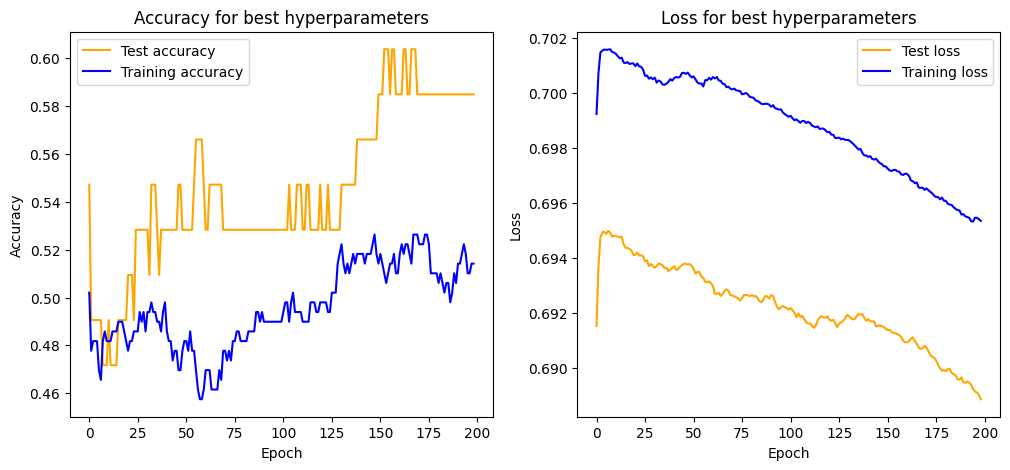

In [18]:
# Generate Plots
fig, ax = plt.subplots(1, 2)
epoch = range(199)
ax[0].plot(epoch, test_acc, color="orange", label="Test accuracy")
ax[0].plot(epoch, train_acc, color="blue", label="Training accuracy")
ax[0].set_title("Accuracy for best hyperparameters")
ax[0].set_ylabel("Accuracy")
ax[0].set_xlabel("Epoch")
ax[0].legend()
ax[1].plot(epoch, test_loss, color="orange", label="Test loss")
ax[1].plot(epoch, train_loss, color="blue", label="Training loss")
ax[1].set_title("Loss for best hyperparameters")
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("Epoch")
ax[1].legend()
fig.set_size_inches(12,5)

In [22]:
# fix random seed
np.random.seed(836365)
torch.manual_seed(836365)
'''
#Run 1 #2 Parameters
filter_sizing = 4
dropout = 0.212
depth_param = 2
model = EEGNET(filter_sizing,dropout,depth_param,N_CHANNELS,mean_pool=15,receptive_field=320)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.000741)
'''

#Run 2 #2 Parameters
filter_sizing = 3
dropout = 0.707
depth_param = 4
model = EEGNET(filter_sizing,dropout,depth_param,N_CHANNELS,mean_pool=15,receptive_field=640)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1.281e-5)

# Train network
train_loss2, test_loss2, train_acc2, test_acc2 = train(model, criterion, optimizer, train_loader, valid_loader, 200)

| epoch  1 | train loss 0.691589 | train acc 0.534413 | valid loss 0.690466 | valid acc 0.509434 |
| epoch  2 | train loss 0.693027 | train acc 0.566802 | valid loss 0.690916 | valid acc 0.490566 |
| epoch  3 | train loss 0.693149 | train acc 0.558704 | valid loss 0.690495 | valid acc 0.452830 |
| epoch  4 | train loss 0.692224 | train acc 0.558704 | valid loss 0.690706 | valid acc 0.433962 |
| epoch  5 | train loss 0.691649 | train acc 0.554656 | valid loss 0.690642 | valid acc 0.415094 |
| epoch  6 | train loss 0.691389 | train acc 0.550607 | valid loss 0.690426 | valid acc 0.415094 |
| epoch  7 | train loss 0.691630 | train acc 0.554656 | valid loss 0.690028 | valid acc 0.433962 |
| epoch  8 | train loss 0.691689 | train acc 0.554656 | valid loss 0.689317 | valid acc 0.433962 |
| epoch  9 | train loss 0.691373 | train acc 0.558704 | valid loss 0.688942 | valid acc 0.433962 |
| epoch 10 | train loss 0.691840 | train acc 0.538462 | valid loss 0.688372 | valid acc 0.452830 |
| epoch 11

In [ ]:
# Generate Plots
fig, ax = plt.subplots(1, 2)
epoch = range(199)
ax[0].plot(epoch, test_acc2, color="orange", label="Test accuracy")
ax[0].plot(epoch, train_acc2, color="blue", label="Training accuracy")
ax[0].set_title("Accuracy for 2nd best hyperparameters")
ax[0].set_ylabel("Accuracy")
ax[0].set_xlabel("Epoch")
ax[0].legend()
ax[1].plot(epoch, test_loss2, color="orange", label="Test loss")
ax[1].plot(epoch, train_loss2, color="blue", label="Training loss")
ax[1].set_title("Loss for 2nd best hyperparameters")
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("Epoch")
ax[1].legend()
fig.set_size_inches(12,5)